## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
import tensorflow as tf

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], mode=0):
    """Code Here
    建立你的神經網路
    mode 0 : BN before activation, default
    mode 1 : BN after activation
    mode 2 : BN after input layer
    """
    input_layer = keras.layers.Input(input_shape)
    
    if mode == 2:
        x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if mode == 2:
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
        elif mode == 1:
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
                x = BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
                x = BatchNormalization()(x)
        else:
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       name="hidden_layer"+str(i+1))(input_layer)
                x = BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       name="hidden_layer"+str(i+1))(x)
                x = BatchNormalization()(x)
                x = keras.layers.Activation("relu")(x)          
                
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 5e-3
EPOCHS = [20, 30, 35, 45, 50]
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
MODE = [0, 1, 2]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, batchsize in enumerate(BATCH_SIZE): 
    for nMode in MODE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with batchsize = %d, mode%d" % (batchsize, nMode))
        model = build_mlp(input_shape=x_train.shape[1:], mode=nMode)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS[i], 
                  batch_size=batchsize, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-bs-%d-m%d" % (batchsize, nMode)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Experiment with batchsize = 2, mode0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activati

50000/50000 [==============================] - 333s 7ms/step - loss: 2.2725 - accuracy: 0.1356 - val_loss: 204.4157 - val_accuracy: 0.1537
Epoch 13/20
50000/50000 [==============================] - 323s 6ms/step - loss: 2.2727 - accuracy: 0.1371 - val_loss: 6353.6212 - val_accuracy: 0.1592
Epoch 14/20
50000/50000 [==============================] - 322s 6ms/step - loss: 2.2695 - accuracy: 0.1380 - val_loss: 1619.7574 - val_accuracy: 0.1545
Epoch 15/20
50000/50000 [==============================] - 333s 7ms/step - loss: 2.2720 - accuracy: 0.1376 - val_loss: 8006.3622 - val_accuracy: 0.1307
Epoch 16/20
50000/50000 [==============================] - 318s 6ms/step - loss: 2.2768 - accuracy: 0.1339 - val_loss: 11.5476 - val_accuracy: 0.1402
Epoch 17/20
50000/50000 [==============================] - 290s 6ms/step - loss: 2.2726 - accuracy: 0.1367 - val_loss: 11649.9101 - val_accuracy: 0.1519
Epoch 18/20
50000/50000 [==============================] - 275s 5ms/step - loss: 2.2698 - accuracy: 0.

Epoch 6/30
50000/50000 [==============================] - 35s 701us/step - loss: 1.2813 - accuracy: 0.5440 - val_loss: 1.4033 - val_accuracy: 0.5080
Epoch 7/30
50000/50000 [==============================] - 32s 644us/step - loss: 1.2491 - accuracy: 0.5561 - val_loss: 1.3511 - val_accuracy: 0.5230
Epoch 8/30
50000/50000 [==============================] - 36s 712us/step - loss: 1.2128 - accuracy: 0.5695 - val_loss: 1.5283 - val_accuracy: 0.4615
Epoch 9/30
50000/50000 [==============================] - 37s 736us/step - loss: 1.1714 - accuracy: 0.5840 - val_loss: 1.3428 - val_accuracy: 0.5280
Epoch 10/30
50000/50000 [==============================] - 31s 626us/step - loss: 1.1482 - accuracy: 0.5931 - val_loss: 1.4420 - val_accuracy: 0.5029
Epoch 11/30
50000/50000 [==============================] - 38s 765us/step - loss: 1.1149 - accuracy: 0.6043 - val_loss: 1.4306 - val_accuracy: 0.4958
Epoch 12/30
50000/50000 [==============================] - 30s 608us/step - loss: 1.0830 - accuracy: 0.6

50000/50000 [==============================] - 32s 645us/step - loss: 1.3268 - accuracy: 0.5299 - val_loss: 1.4672 - val_accuracy: 0.4860
Epoch 21/30
50000/50000 [==============================] - 37s 740us/step - loss: 1.3191 - accuracy: 0.5322 - val_loss: 1.3594 - val_accuracy: 0.5182
Epoch 22/30
50000/50000 [==============================] - 32s 632us/step - loss: 1.3040 - accuracy: 0.5387 - val_loss: 1.3594 - val_accuracy: 0.5137
Epoch 23/30
50000/50000 [==============================] - 37s 749us/step - loss: 1.2890 - accuracy: 0.5434 - val_loss: 1.3422 - val_accuracy: 0.5229
Epoch 24/30
50000/50000 [==============================] - 37s 733us/step - loss: 1.2823 - accuracy: 0.5448 - val_loss: 1.3586 - val_accuracy: 0.5213
Epoch 25/30
50000/50000 [==============================] - 34s 671us/step - loss: 1.2851 - accuracy: 0.5445 - val_loss: 1.3647 - val_accuracy: 0.5221
Epoch 26/30
50000/50000 [==============================] - 38s 753us/step - loss: 1.2728 - accuracy: 0.5479 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/35
50000/50000 [==============================] - 19s 379us/step - loss: 1.6513 - accuracy: 0.4095 - val_loss: 1.5990 - val_accuracy: 0.4238
Epoch 2/35
50000/50000 [==============================] - 19s 389us/step - loss: 1.4438 - accuracy: 0.4858 - val_loss: 1.5650 - val_accuracy: 0.4394
Epoch 3/35
50000/50000 [==============================] - 19s 370us/step - loss: 1.3441 - accuracy: 0.5194 - val_loss: 1.6307 - val_accuracy: 0.4251
Epoch 4/35
50000/50000 [==============================] - 15s 291us/step - loss: 1.2620 - accuracy: 0.5514 - val_loss: 1.4331 - val_accuracy: 0.4918
Epoch 5/35
50000/50000 [==============================] - 17s 344us/step - loss: 1.2023 - accuracy: 0.5696 - val_loss: 1.5413 - val_accuracy: 0.4591
Epoch 6/35
50000/50000 [==============================] - 20s 409us/step - loss: 1.1386 - accuracy: 0.5929 - val_loss: 1.4303 - val_accuracy: 0.5009
Epoch 7/35
50000/50000 [==============================] 

50000/50000 [==============================] - 19s 372us/step - loss: 1.2741 - accuracy: 0.5453 - val_loss: 1.4384 - val_accuracy: 0.4841
Epoch 11/35
50000/50000 [==============================] - 19s 372us/step - loss: 1.2477 - accuracy: 0.5556 - val_loss: 1.3676 - val_accuracy: 0.5151
Epoch 12/35
50000/50000 [==============================] - 16s 311us/step - loss: 1.2281 - accuracy: 0.5647 - val_loss: 1.3956 - val_accuracy: 0.5046
Epoch 13/35
50000/50000 [==============================] - 17s 345us/step - loss: 1.2099 - accuracy: 0.5706 - val_loss: 1.5563 - val_accuracy: 0.4645
Epoch 14/35
50000/50000 [==============================] - 22s 432us/step - loss: 1.1899 - accuracy: 0.5759 - val_loss: 1.5257 - val_accuracy: 0.4634
Epoch 15/35
50000/50000 [==============================] - 15s 301us/step - loss: 1.1731 - accuracy: 0.5820 - val_loss: 1.4101 - val_accuracy: 0.5062
Epoch 16/35
50000/50000 [==============================] - 16s 317us/step - loss: 1.1632 - accuracy: 0.5848 - va

50000/50000 [==============================] - 15s 291us/step - loss: 0.7896 - accuracy: 0.7223 - val_loss: 1.6339 - val_accuracy: 0.5315
Epoch 22/35
50000/50000 [==============================] - 18s 365us/step - loss: 0.7831 - accuracy: 0.7284 - val_loss: 1.6639 - val_accuracy: 0.5355
Epoch 23/35
50000/50000 [==============================] - 16s 317us/step - loss: 0.7525 - accuracy: 0.7392 - val_loss: 1.7232 - val_accuracy: 0.5249
Epoch 24/35
50000/50000 [==============================] - 14s 273us/step - loss: 0.7352 - accuracy: 0.7456 - val_loss: 1.7082 - val_accuracy: 0.5337
Epoch 25/35
50000/50000 [==============================] - 18s 364us/step - loss: 0.7297 - accuracy: 0.7460 - val_loss: 1.7218 - val_accuracy: 0.5368
Epoch 26/35
50000/50000 [==============================] - 16s 326us/step - loss: 0.6995 - accuracy: 0.7575 - val_loss: 1.7370 - val_accuracy: 0.5214
Epoch 27/35
50000/50000 [==============================] - 14s 279us/step - loss: 0.6831 - accuracy: 0.7646 - va

50000/50000 [==============================] - 9s 179us/step - loss: 0.1607 - accuracy: 0.9431 - val_loss: 2.8650 - val_accuracy: 0.4687
Epoch 29/45
50000/50000 [==============================] - 8s 165us/step - loss: 0.1490 - accuracy: 0.9491 - val_loss: 2.9413 - val_accuracy: 0.4855
Epoch 30/45
50000/50000 [==============================] - 6s 128us/step - loss: 0.1342 - accuracy: 0.9541 - val_loss: 2.8589 - val_accuracy: 0.4955
Epoch 31/45
50000/50000 [==============================] - 6s 126us/step - loss: 0.1230 - accuracy: 0.9578 - val_loss: 3.3263 - val_accuracy: 0.4586
Epoch 32/45
50000/50000 [==============================] - 6s 120us/step - loss: 0.1169 - accuracy: 0.9611 - val_loss: 2.9457 - val_accuracy: 0.4862
Epoch 33/45
50000/50000 [==============================] - 5s 107us/step - loss: 0.1134 - accuracy: 0.9615 - val_loss: 3.2457 - val_accuracy: 0.4546
Epoch 34/45
50000/50000 [==============================] - 5s 108us/step - loss: 0.1050 - accuracy: 0.9647 - val_loss:

50000/50000 [==============================] - 5s 107us/step - loss: 0.6650 - accuracy: 0.7604 - val_loss: 1.8460 - val_accuracy: 0.4703
Epoch 29/45
50000/50000 [==============================] - 5s 110us/step - loss: 0.6401 - accuracy: 0.7706 - val_loss: 1.9571 - val_accuracy: 0.4658
Epoch 30/45
50000/50000 [==============================] - 5s 107us/step - loss: 0.6156 - accuracy: 0.7797 - val_loss: 1.8282 - val_accuracy: 0.4894
Epoch 31/45
50000/50000 [==============================] - 6s 119us/step - loss: 0.5992 - accuracy: 0.7863 - val_loss: 1.9692 - val_accuracy: 0.4666
Epoch 32/45
50000/50000 [==============================] - 6s 116us/step - loss: 0.5785 - accuracy: 0.7937 - val_loss: 2.0262 - val_accuracy: 0.4629
Epoch 33/45
50000/50000 [==============================] - 6s 115us/step - loss: 0.5699 - accuracy: 0.7929 - val_loss: 2.0229 - val_accuracy: 0.4807
Epoch 34/45
50000/50000 [==============================] - 6s 123us/step - loss: 0.5465 - accuracy: 0.8030 - val_loss:

Epoch 30/45
50000/50000 [==============================] - 5s 110us/step - loss: 0.2192 - accuracy: 0.9211 - val_loss: 2.6765 - val_accuracy: 0.5329
Epoch 31/45
50000/50000 [==============================] - 5s 110us/step - loss: 0.2072 - accuracy: 0.9272 - val_loss: 2.8185 - val_accuracy: 0.5265
Epoch 32/45
50000/50000 [==============================] - 6s 115us/step - loss: 0.2120 - accuracy: 0.9249 - val_loss: 2.8243 - val_accuracy: 0.5252
Epoch 33/45
50000/50000 [==============================] - 6s 125us/step - loss: 0.1990 - accuracy: 0.9319 - val_loss: 2.9469 - val_accuracy: 0.5314
Epoch 34/45
50000/50000 [==============================] - 8s 156us/step - loss: 0.1877 - accuracy: 0.9349 - val_loss: 2.9902 - val_accuracy: 0.5264
Epoch 35/45
50000/50000 [==============================] - 9s 180us/step - loss: 0.1829 - accuracy: 0.9368 - val_loss: 2.9702 - val_accuracy: 0.5378
Epoch 36/45
50000/50000 [==============================] - 7s 140us/step - loss: 0.1899 - accuracy: 0.9354

50000/50000 [==============================] - 4s 80us/step - loss: 0.1206 - accuracy: 0.9623 - val_loss: 2.9395 - val_accuracy: 0.4650
Epoch 28/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.1092 - accuracy: 0.9662 - val_loss: 3.1409 - val_accuracy: 0.4524
Epoch 29/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.0937 - accuracy: 0.9715 - val_loss: 3.5863 - val_accuracy: 0.4308
Epoch 30/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.0879 - accuracy: 0.9736 - val_loss: 3.0018 - val_accuracy: 0.4631
Epoch 31/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.0859 - accuracy: 0.9741 - val_loss: 3.0260 - val_accuracy: 0.4780
Epoch 32/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.0808 - accuracy: 0.9756 - val_loss: 3.1910 - val_accuracy: 0.4654
Epoch 33/50
50000/50000 [==============================] - 6s 116us/step - loss: 0.0739 - accuracy: 0.9781 - val_loss: 2.927

50000/50000 [==============================] - 4s 85us/step - loss: 0.6099 - accuracy: 0.7845 - val_loss: 2.0947 - val_accuracy: 0.4272
Epoch 23/50
50000/50000 [==============================] - 4s 84us/step - loss: 0.5924 - accuracy: 0.7903 - val_loss: 1.8968 - val_accuracy: 0.4644
Epoch 24/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.5513 - accuracy: 0.8060 - val_loss: 1.8866 - val_accuracy: 0.4869
Epoch 25/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.5266 - accuracy: 0.8144 - val_loss: 2.0629 - val_accuracy: 0.4689
Epoch 26/50
50000/50000 [==============================] - 6s 118us/step - loss: 0.5075 - accuracy: 0.8217 - val_loss: 2.2317 - val_accuracy: 0.4384
Epoch 27/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.4903 - accuracy: 0.8260 - val_loss: 2.1950 - val_accuracy: 0.4635
Epoch 28/50
50000/50000 [==============================] - 5s 98us/step - loss: 0.4683 - accuracy: 0.8338 - val_loss: 2.60

Epoch 19/50
50000/50000 [==============================] - 726s 15ms/step - loss: 0.3057 - accuracy: 0.8949 - val_loss: 2.2087 - val_accuracy: 0.5270
Epoch 20/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.2939 - accuracy: 0.8969 - val_loss: 2.3266 - val_accuracy: 0.5186
Epoch 21/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.2595 - accuracy: 0.9106 - val_loss: 2.3616 - val_accuracy: 0.5187
Epoch 22/50
50000/50000 [==============================] - 3s 69us/step - loss: 0.2521 - accuracy: 0.9124 - val_loss: 2.4506 - val_accuracy: 0.5191
Epoch 23/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.2261 - accuracy: 0.9227 - val_loss: 2.5107 - val_accuracy: 0.5173
Epoch 24/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.2056 - accuracy: 0.9294 - val_loss: 2.5767 - val_accuracy: 0.5166
Epoch 25/50
50000/50000 [==============================] - 3s 66us/step - loss: 0.1837 - accuracy: 0.9366 - va

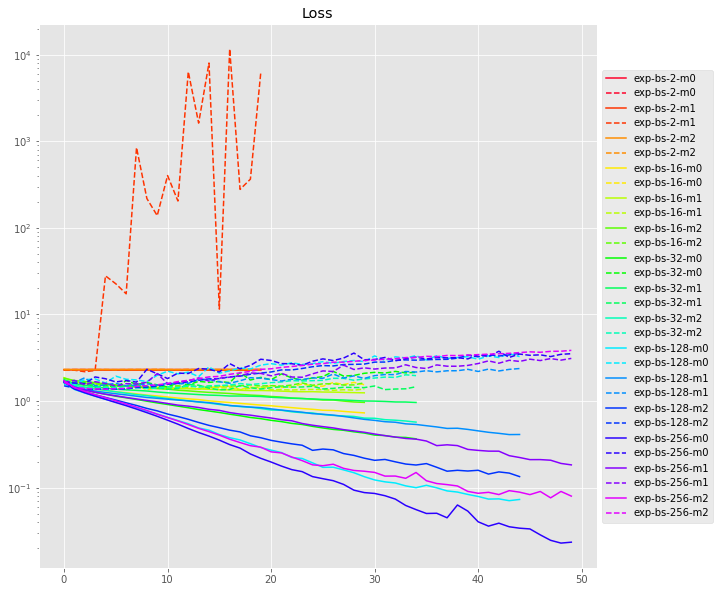

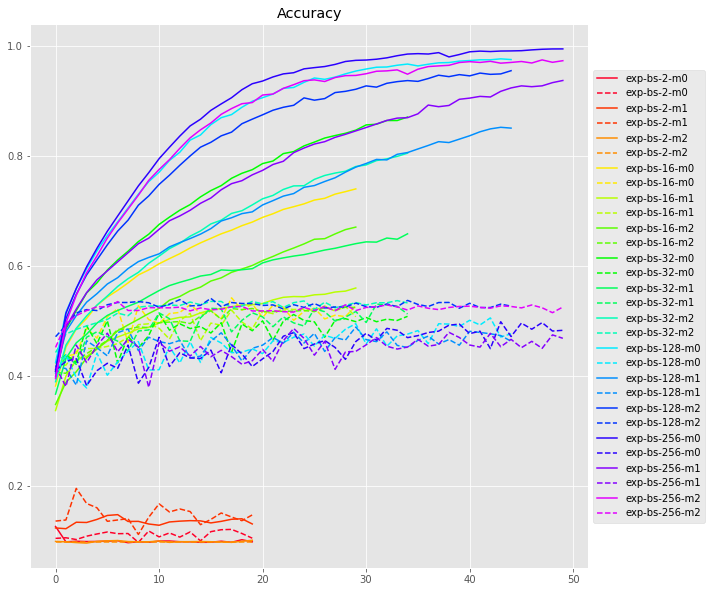

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
plt.style.use('ggplot')
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
#color_bar = ["r", "g", "b", "c", "y", "m", "k", "w"]

plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(10,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()